In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from numpy import mean
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_json(r'ultimate_data_challenge.json')

In [3]:
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [4]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [7]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In this scenario the missing values are generally small compared to the total data so we can drop the data in this case. We could use the average values in other columns but this may just weaken the trends in the data

In [8]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41445 non-null  object        
 1   trips_in_first_30_days  41445 non-null  int64         
 2   signup_date             41445 non-null  datetime64[ns]
 3   avg_rating_of_driver    41445 non-null  float64       
 4   avg_surge               41445 non-null  float64       
 5   last_trip_date          41445 non-null  datetime64[ns]
 6   phone                   41445 non-null  object        
 7   surge_pct               41445 non-null  float64       
 8   ultimate_black_user     41445 non-null  bool          
 9   weekday_pct             41445 non-null  float64       
 10  avg_dist                41445 non-null  float64       
 11  avg_rating_by_driver    41445 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

<AxesSubplot:>

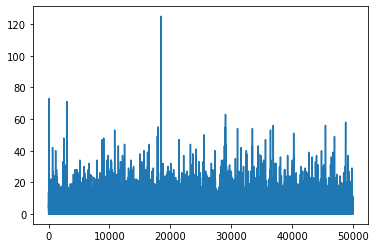

In [9]:
df['trips_in_first_30_days'].plot()

<AxesSubplot:>

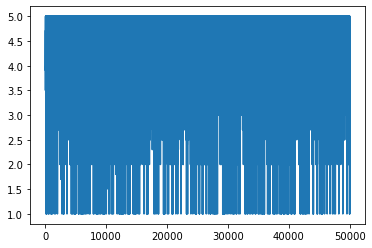

In [10]:
df['avg_rating_of_driver'].plot()

<AxesSubplot:>

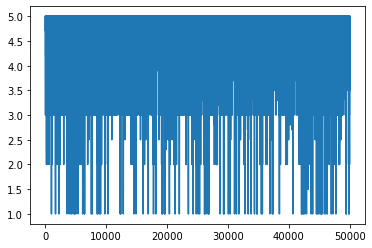

In [11]:
df['avg_rating_by_driver'].plot()

<AxesSubplot:>

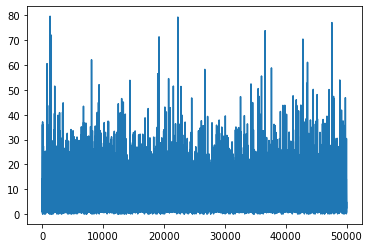

In [12]:
df['avg_dist'].plot()

<AxesSubplot:>

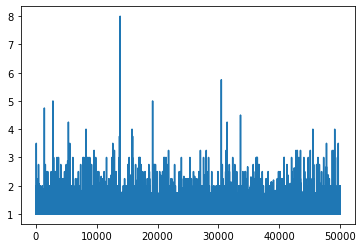

In [13]:
df['avg_surge'].plot()

During our cleaning and exploratory analysis phase we decided to drop the missing value columns since it was not too large a portion of the data. 41,445 entries were kept which is 83%. we converted the columns to the correct data types and plotted the numerical data to get a sense of what the distributions look like. The data seems to be mostly flat across the board with a few large outliers in each column. This is something to keep in mind as a way to improve our model in the future may be to remove the outliers

In [14]:
df['hold'] = df['signup_date'] + pd.DateOffset(months =6)
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,hold
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-07-25
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-07-29
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-07-06
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-07-10
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-07-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,Astapor,3,2014-01-03,4.8,1.11,2014-07-01,iPhone,11.1,True,55.6,2.53,4.7,2014-07-03
49994,Astapor,1,2014-01-03,4.6,1.44,2014-05-31,iPhone,37.5,False,25.0,2.25,4.5,2014-07-03
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,2014-07-25
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,2014-07-31


In [15]:
df['6_months'] = df['hold'] <= df['last_trip_date']

In [16]:
df['6_months'].value_counts()

False    41433
True        12
Name: 6_months, dtype: int64

In [17]:
#get_dummies
df.drop(columns = ['signup_date','last_trip_date','hold'], inplace=True)
dfo = df[['city','phone','ultimate_black_user']]
df = pd.concat([df.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)

The dataset is very unbalanced so we will do under sampling and smote to get our datasets balanced

In [18]:
X = df.drop(columns  = ['6_months'])
y = df['6_months']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
print("Before undersampling: ", Counter(y_train))
undersample = RandomUnderSampler(sampling_strategy=.3)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print("After undersampling: ", Counter(y_train_under))


Before undersampling:  Counter({False: 33146, True: 10})
After undersampling:  Counter({False: 33, True: 10})


In [19]:
model=svm.SVC()
clf_under = model.fit(X_train_under, y_train_under)
pred_under = clf_under.predict(X_test)
print("ROC AUC score for undersampled data: ", roc_auc_score(y_test, pred_under))


ROC AUC score for undersampled data:  0.5


We want to try to improve on this ROC score so we will iterate through the values for both under and oversampling in order to find the best splits 

In [28]:
from sklearn.preprocessing import StandardScaler
model = svm.SVC()
over = SMOTE(sampling_strategy = .05)
under = RandomUnderSampler(sampling_strategy=0.5)
standard = StandardScaler()
steps = [('standard', standard),('o', over), ('u', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [29]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
score = mean(scores)
print('ROC AUC score for the combined sampling method: %.3f' % score)

ROC AUC score for the combined sampling method: 0.676


In [30]:
over_values = [0.1,0.04,1]
under_values = [.1,0.3,0.05]
for o in over_values:
    for u in under_values:
        # define pipeline
        model = svm.SVC()
        over = SMOTE(sampling_strategy=o)
        under = RandomUnderSampler(sampling_strategy=u)
        standard = StandardScaler()
        steps = [('standard', standard),('o', over), ('u', under), ('model', model)]
        pipeline = Pipeline(steps=steps)
    # evaluate pipeline
        scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
        score = mean(scores)
        print('SMOTE oversampling rate:%.3f, Random undersampling rate:%.1f , Mean ROC AUC: %.3f' % (o, u, score))

SMOTE oversampling rate:0.100, Random undersampling rate:0.1 , Mean ROC AUC: 0.686
SMOTE oversampling rate:0.100, Random undersampling rate:0.3 , Mean ROC AUC: 0.682
SMOTE oversampling rate:0.100, Random undersampling rate:0.1 , Mean ROC AUC: nan
SMOTE oversampling rate:0.040, Random undersampling rate:0.1 , Mean ROC AUC: 0.696
SMOTE oversampling rate:0.040, Random undersampling rate:0.3 , Mean ROC AUC: 0.693
SMOTE oversampling rate:0.040, Random undersampling rate:0.1 , Mean ROC AUC: 0.701
SMOTE oversampling rate:1.000, Random undersampling rate:0.1 , Mean ROC AUC: nan
SMOTE oversampling rate:1.000, Random undersampling rate:0.3 , Mean ROC AUC: nan
SMOTE oversampling rate:1.000, Random undersampling rate:0.1 , Mean ROC AUC: nan


In [32]:
model = svm.SVC()
over = SMOTE(sampling_strategy=.04)
under = RandomUnderSampler(sampling_strategy=.1)
standard = StandardScaler()
steps = [('standard', standard),('o', over), ('u', under), ('model', model)]
pipeline = Pipeline(steps=steps)
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
score = mean(scores)
print(score)

0.7017059977875894


In [42]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[8264,   23],
       [   2,    0]], dtype=int64)

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Precision: 0.000
Recall: 0.000
Accuracy: 0.997
F1 Score: 0.000


In this study with only 12 true values and 41,000 false values I was unable to find a model that could accurately predict future users who would stay past 6 months